--2024-11-20 05:18:16--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 108.157.254.15, 108.157.254.121, 108.157.254.124, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|108.157.254.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘/content/sam_vit_h_4b8939.pth’

/content/sam_vit_h_ 100%[===================>]   2.39G  83.2MB/s    in 20s     

2024-11-20 05:18:37 (119 MB/s) - ‘/content/sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading SAM model...
Model loaded on device: cuda
Processing Training/case1...


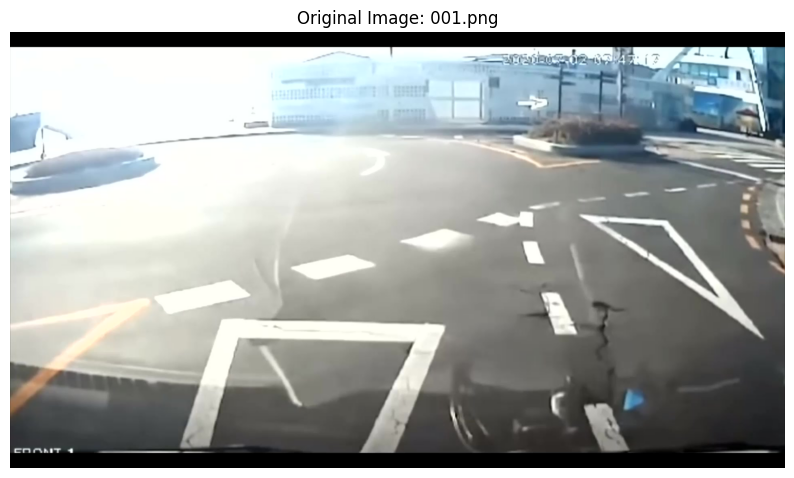

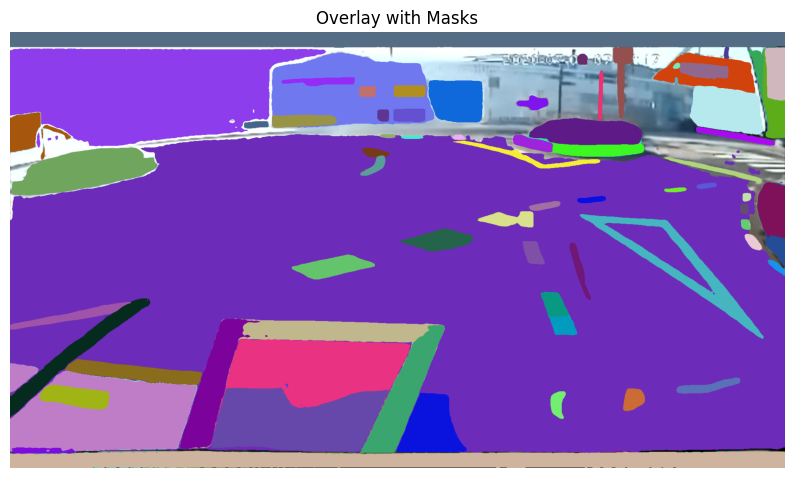

Processed image: /content/drive/MyDrive/dataset/Training/case1/001.png


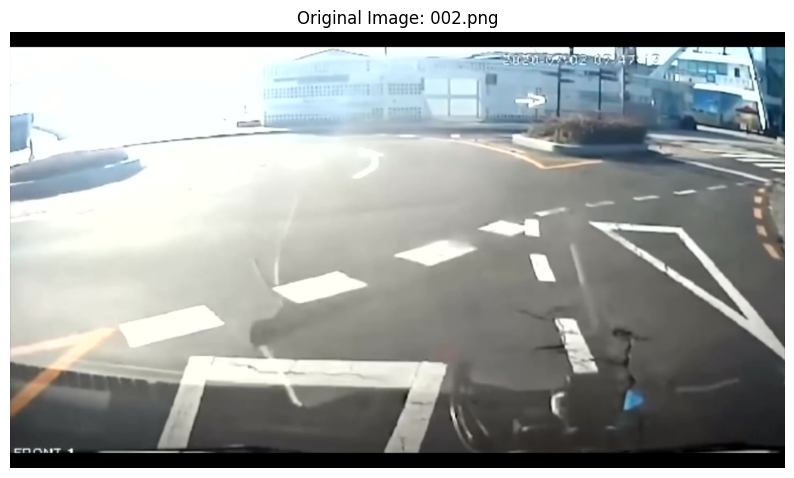

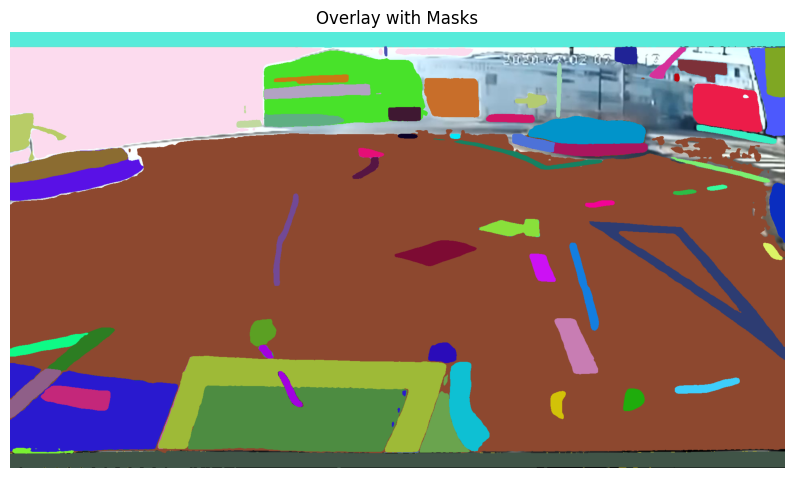

Processed image: /content/drive/MyDrive/dataset/Training/case1/002.png


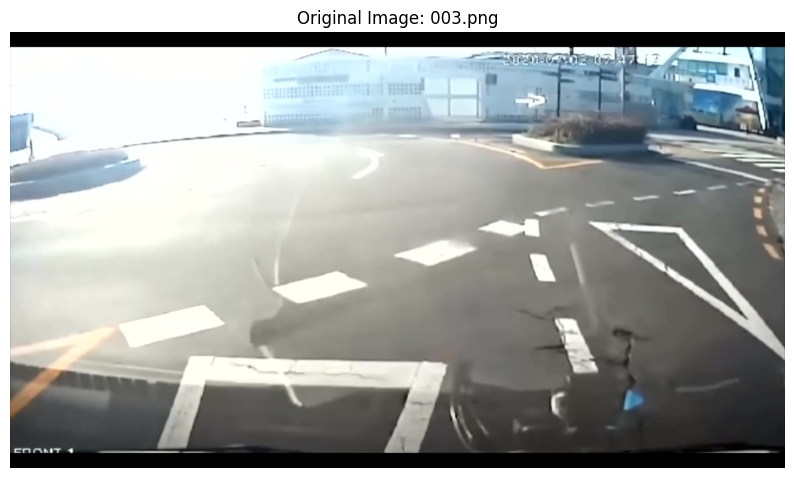

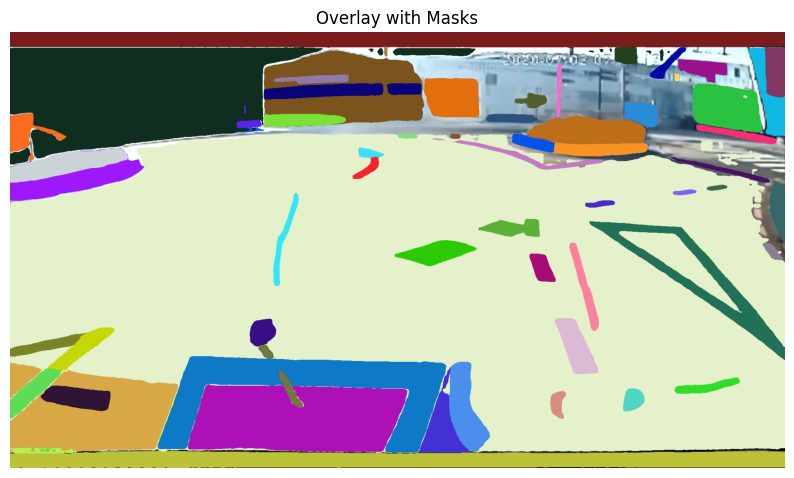

Processed image: /content/drive/MyDrive/dataset/Training/case1/003.png


In [3]:
# 필요한 라이브러리 설치
!pip install segment-anything opencv-python-headless torch torchvision matplotlib numpy

# GitHub에서 SAM 모델 다운로드
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -O /content/sam_vit_h_4b8939.pth

# 라이브러리 임포트
import os
import cv2
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry
from google.colab import drive

# Google Drive 마운트
drive.mount('/content/drive')

# 모델 경로 및 기본 설정
sam_checkpoint = '/content/sam_vit_h_4b8939.pth'  # 모델 파일 경로
model_type = "vit_h"  # 모델 타입
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # GPU 또는 CPU

# SAM 모델 로드
print("Loading SAM model...")
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint).to(device)
mask_generator = SamAutomaticMaskGenerator(sam)
print(f"Model loaded on device: {device}")

# 데이터셋 경로 설정
dataset_path = "/content/drive/MyDrive/dataset"  # Google Drive에 있는 dataset 폴더 경로

# 이미지 리사이징 함수
def resize_image(image, target_size=(256, 256)):
    return cv2.resize(image, target_size)

# 이미지 처리 및 가시화 함수
def recognize_and_visualize(image_path, mask_generator):
    try:
        # 이미지 로드
        image = cv2.imread(image_path)
        if image is None:
            print(f"[WARNING] Could not read image: {image_path}")
            return
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # 마스크 생성
        masks = mask_generator.generate(image_rgb)

        # 가시화: 원본 이미지
        plt.figure(figsize=(10, 10))
        plt.imshow(image_rgb)
        plt.title(f"Original Image: {os.path.basename(image_path)}")
        plt.axis("off")
        plt.show()

        # 마스크 오버레이
        overlay = image_rgb.copy()
        for mask in masks:
            color = [int(c) for c in np.random.randint(0, 255, size=3)]  # 랜덤 색상
            mask_overlay = mask["segmentation"]
            overlay[mask_overlay] = color

        plt.figure(figsize=(10, 10))
        plt.imshow(overlay)
        plt.title("Overlay with Masks")
        plt.axis("off")
        plt.show()

        print(f"Processed image: {image_path}")
    except Exception as e:
        print(f"[ERROR] Failed to process image {image_path}: {e}")

# 데이터셋 처리 함수
def process_dataset(dataset_path, num_images=5):
    categories = ["Training"]  # Validation 카테고리를 제외하고 Training만 처리

    for category in categories:
        category_path = os.path.join(dataset_path, category)
        if not os.path.exists(category_path):
            print(f"[WARNING] Folder not found: {category_path}")
            continue

        case_folders = os.listdir(category_path)
        for case_folder in case_folders:
            case_path = os.path.join(category_path, case_folder)
            if os.path.isdir(case_path):
                image_files = [f for f in sorted(os.listdir(case_path)) if f.endswith('.png')]
                print(f"Processing {category}/{case_folder}...")

                for image_file in image_files[:num_images]:
                    image_path = os.path.join(case_path, image_file)
                    recognize_and_visualize(image_path, mask_generator)
                    time.sleep(1)  # 딜레이 추가

# 실행
process_dataset(dataset_path, num_images=3)  # 폴더별 최대 3개 이미지 처리
